In [1]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
import plotly.express as px
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [2]:
scz_path = 'clean_data/SCZ/schaefer1000'
controls_path = 'clean_data/controls/schaefer1000'

In [3]:
scz_subjects = np.loadtxt('COBRE_SCZ_subjects.txt', dtype = str)
control_subjects = np.loadtxt('COBRE_controls_subjects.txt', dtype = str)


In [4]:
panss = pd.read_csv('COBRE_assessmentData_17938.csv')
len(panss)
panss.replace({'Absent': 1, 'Minimal': 2, 'Mild': 3, 'MD':3, 'Moderate': 4, 'Moderate severe': 5, 'Severe': 6, 'Extreme': 7}, inplace=True)
panss = panss.dropna(subset = ["question_value"])
panss["question_value"] = panss["question_value"].astype(int)


2220

In [5]:
panss_total = pd.DataFrame(columns=['SubjectID', 'PANSS_Total'])

for subject in scz_subjects:
    df_subject = panss[panss['subjectid'] == subject]
    total_score = df_subject['question_value'].sum()
    panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_79490/7172851.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_79490/7172851.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_79490/7172851.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panss_total = panss_total.append({'SubjectID': subject, 'PANSS_Total': total_score}, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn

In [7]:
# save the total scores to a csv file
panss_total.to_csv('panss_total.csv', index=False)

# Pipeline
1. Normalize gradients relative to the neurotypical group gradient.
2. Multiple Linear Regression + LOO-CV
3. Support Vector Regression + LOO-CV


## 1. Gradient Normalization

In [8]:
X_scz_grads = []

for subject in scz_subjects:
    subject_path = f'{scz_path}/sub-{subject}/func'
    grads = np.load(f'{subject_path}/aligned_10grads_{subject}_schaefer1000.npy')
    X_scz_grads.append(grads)

X_scz_grads = np.stack(X_scz_grads)

control_grads = []
for subject in control_subjects:
    subject_path = f'{controls_path}/sub-{subject}/func'
    grads = np.load(f'{subject_path}/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads.append(grads)

control_grads = np.stack(control_grads)


In [9]:
control_grads_reshaped = control_grads.reshape(control_grads.shape[0], -1)
X_scz_grads_reshaped = X_scz_grads.reshape(X_scz_grads.shape[0], -1)


In [10]:
control_grads_reshaped.shape
X_scz_grads_reshaped.shape


(91, 10000)

(73, 10000)

In [11]:
scaler = StandardScaler()
scaler.fit(control_grads_reshaped)
X_scz_grads_norm = scaler.transform(X_scz_grads_reshaped)

X_scz_grads_norm = X_scz_grads_norm.reshape(X_scz_grads.shape)


StandardScaler()

In [12]:
X_scz_grads_norm.shape

(73, 1000, 10)

## 2.1 Muptiple Linear Regression on Gradients + LOO-CV


In [15]:
grad_combinations = np.arange(1, 11)

# Initialize a DataFrame to store the results
linreg_df = pd.DataFrame(columns=["Num_Gradients", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

# Loop over the gradient combinations
for n_grads in grad_combinations:
    # Select the specified gradients for both control and patient data
    X_scz_grads_norm_sub = X_scz_grads_norm[:, :, n_grads-1]
    y_scz = panss_total['PANSS_Total'].values

    # Initialize the LOOCV object
    loocv = LeaveOneOut()

    # Initialize lists to store the MSE for each fold
    mse_train = []
    mse_test = []
    mae_train = []
    mae_test = []
    r2_train = []
    r2_test = []
    obs_left_out = []
    actual_scores = []
    predicted_scores_test = []
    predicted_scores_train = []


    # Loop over the LOOCV folds
    for train_idx, test_idx in loocv.split(X_scz_grads_norm_sub):
        reg = LinearRegression()

        # Split the data into training and testing sets
        X_train = X_scz_grads_norm_sub[train_idx]
        y_train = y_scz[train_idx]
        X_test = X_scz_grads_norm_sub[test_idx]
        y_test = y_scz[test_idx]

        # Fit the regression model to the training data
        reg.fit(X_train.reshape(len(train_idx), -1), y_train)

        # Predict the PNASS score for the training and testing data
        y_train_pred = reg.predict(X_train.reshape(len(train_idx), -1))
        y_test_pred = reg.predict(X_test.reshape(1, -1))

        # Calculate the MSE, MAE, vscode-webview://0s8407ja4lfle12o90208dp55topvghfobgfe41snmpsvsq5k2bk/2576395a-4341-442b-95d4-b87661af61d5and R^2 for the training and testing data
        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_test.append(mean_squared_error(y_test, y_test_pred))
        mae_train.append(mean_absolute_error(y_train, y_train_pred))
        mae_test.append(mean_absolute_error(y_test, y_test_pred))
        
        # Append the index of the observation left out and the actual and predicted scores
        obs_left_out.append(test_idx[0])
        actual_scores.append(y_test[0])
        predicted_scores_test.append(y_test_pred[0])
        predicted_scores_train.append(y_train_pred[0])

    r2_train = r2_score(actual_scores, predicted_scores_train)
    r2_test = r2_score(actual_scores, predicted_scores_test)
    # Compute the mean MSE, MAE, and R^2 across all folds for both training and testing data
    mean_mse_train = np.mean(mse_train)
    mean_mse_test = np.mean(mse_test)
    mean_mae_train = np.mean(mae_train)
    mean_mae_test = np.mean(mae_test)

    filename = 'linreg_loocv_grads_panss_perf.csv'
    # Add the results to the DataFrame
    with open(filename, mode='a') as results_file:
        # Create a CSV writer object
        results_writer = csv.writer(results_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        # Write the header row if the file is empty
        if results_file.tell() == 0:
            results_writer.writerow(["Num_Gradients", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

        # Write the results for the current train and test session
        for i in range(len(mse_train)):
            results_writer.writerow([n_grads, mse_train[i], mse_test[i], mae_train[i], mae_test[i], r2_train, r2_test, obs_left_out[i], actual_scores[i], predicted_scores_test[i]])

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

112

150

153

147

150

150

151

151

149

151

151

148

151

151

152

150

151

149

150

153

152

150

151

151

148

152

152

150

151

153

148

152

151

152

150

151

151

152

150

150

149

152

151

150

149

151

151

153

152

150

152

148

152

153

150

153

151

152

150

150

151

150

150

153

152

149

151

152

151

152

150

152

149

151

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

150

148

152

153

151

152

153

151

149

152

151

153

152

151

153

153

150

151

153

150

152

152

151

152

153

152

151

153

152

149

153

152

152

153

152

151

150

152

152

150

149

152

152

153

151

150

152

152

154

149

151

152

153

153

153

153

152

153

154

152

154

152

152

152

152

148

151

154

151

152

152

150

152

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

148

148

150

149

152

150

148

149

149

149

150

150

151

152

150

151

150

151

151

151

151

150

151

152

151

149

149

150

152

152

151

154

150

148

152

152

150

150

151

152

151

152

151

151

152

147

151

151

152

153

151

150

152

152

151

154

152

149

151

154

150

151

150

150

151

152

154

151

149

151

148

150

151

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

150

151

147

151

150

152

149

151

152

153

154

152

155

152

154

154

151

153

152

153

153

152

152

153

152

152

151

152

154

152

152

149

155

152

151

153

151

152

152

152

153

153

153

152

153

153

152

151

152

154

153

155

152

148

150

153

152

153

152

153

150

151

154

153

153

151

153

152

150

154

154

152

153

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

150

151

152

149

148

151

150

151

152

152

151

152

153

147

151

153

150

154

153

152

150

151

149

146

150

153

150

152

152

150

153

150

153

150

151

153

151

151

152

153

152

150

149

151

152

152

155

152

151

148

151

151

151

152

150

152

152

153

151

153

152

151

151

153

157

152

153

152

152

151

151

153

151

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

147

153

151

152

152

151

151

152

153

152

154

153

154

154

151

155

151

151

151

151

151

152

152

152

153

154

154

148

154

153

154

153

151

155

151

151

153

152

153

150

153

153

152

154

150

151

152

152

150

152

150

153

152

152

152

151

153

151

151

155

154

150

152

152

151

150

154

152

152

151

153

152

152

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

150

151

151

154

149

151

152

152

151

154

153

153

150

155

152

152

154

151

152

155

152

151

153

150

150

152

152

150

152

152

154

151

151

154

154

152

152

151

150

152

153

152

152

153

151

151

149

153

153

153

153

154

152

153

152

154

153

152

153

152

153

154

152

152

153

152

153

153

151

151

153

151

151

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

149

152

152

150

151

151

150

149

151

151

150

153

153

150

154

153

153

154

152

154

153

153

153

153

153

153

152

151

152

151

153

149

152

152

150

152

150

152

151

152

151

155

155

153

152

157

153

154

152

151

151

153

153

155

153

153

154

153

154

151

153

154

154

151

151

154

152

155

152

152

151

153

150

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

151

151

150

151

149

149

151

151

149

147

150

150

151

151

147

151

151

149

151

149

149

150

152

148

151

150

153

152

149

147

153

151

151

153

149

151

149

149

150

149

149

149

152

148

150

150

151

150

149

152

147

152

151

151

150

153

149

153

152

150

150

153

151

150

152

152

148

149

149

150

148

151

151

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

152

152

151

150

149

150

151

153

150

149

154

151

150

152

151

152

153

152

151

152

153

151

152

150

151

154

153

151

152

152

149

152

152

150

152

151

152

153

152

153

149

152

152

152

153

152

152

151

156

150

155

151

152

150

153

152

153

152

153

150

150

153

150

151

150

154

154

151

155

151

154

153

151

In [16]:
lingreg_loocv_grads_panss_results = pd.read_csv('linreg_loocv_grads_panss_perf.csv')

In [17]:
lingreg_loocv_grads_panss_results["Rel_Error"] = lingreg_loocv_grads_panss_results["MAE_Test"]/lingreg_loocv_grads_panss_results["Actual_Score"]


In [18]:
lingreg_loocv_grads_panss_results

Num_Gradients     MSE_Train     MSE_Test     MAE_Train   MAE_Test  \
0                1  1.710250e-27   274.827516  3.128362e-14  16.577923   
1                1  1.209587e-27   280.294440  2.773090e-14  16.741996   
2                1  1.821042e-27   206.705669  3.404684e-14  14.377262   
3                1  1.628910e-27   396.602235  3.286260e-14  19.914875   
4                1  1.284616e-27   116.633418  2.881646e-14  10.799695   
..             ...           ...          ...           ...        ...   
725             10  2.132379e-27   383.013524  3.740218e-14  19.570731   
726             10  7.902633e-28   300.829571  2.299395e-14  17.344439   
727             10  1.748817e-27  1319.194732  3.019807e-14  36.320720   
728             10  1.617691e-27   156.327961  3.207311e-14  12.503118   
729             10  7.972754e-28     9.820868  2.240183e-14   3.133826   

     R2_Train   R2_Test  Obs_Left_Out  Actual_Score  Predicted_Score  \
0   -0.018355 -0.203613             0            57        40.422077   
1   -0.018355 -0.203613             1            47        63.741996   
2   -0.018355 -0.203613             2            47        61.377262   
3   -0.018355 -0.203613             3            41        60.914875   
4   -0.018355 -0.203613             4            39        49.799695   
..        ...       ...           ...           ...              ...   
725 -0.018355 -0.292055            68            36        55.570731   
726 -0.018355 -0.292055            69            40        57.344439   
727 -0.018355 -0.292055            70            83        46.679280   
728 -0.018355 -0.292055            71            70        57.496882   
729 -0.018355 -0.292055            72            55        58.133826   

     Rel_Error  
0     0.290841  
1     0.356213  
2     0.305899  
3     0.485729  
4     0.276915  
..         ...  
725   0.543631  
726   0.433611  
727   0.437599  
728   0.178616  
729   0.056979  

[730 rows x 11 columns]

Text(0.5, 1.0, 'LinReg fit on single gradients')

Text(0.5, 0, 'Number of Gradients')

Text(0, 0.5, 'Mean Relative Error')

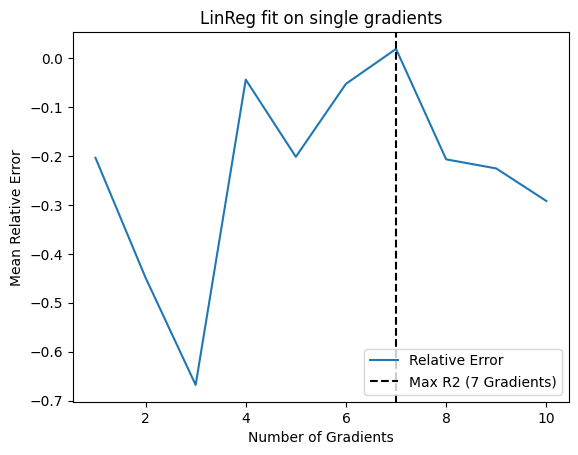

In [22]:
# Compute the mean and standard error of the mean for each number of gradients
mean_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["Rel_Error"].mean()
mean_r2_test = lingreg_loocv_grads_panss_results.groupby("Num_Gradients")["R2_Test"].mean()


num_gradients_min_error = mean_test.idxmin()
num_gradients_r2_max = mean_r2_test.idxmax()


# Plot the means and standard errors
fig, ax = plt.subplots()

# Add title
ax.set_title('LinReg fit on single gradients')


ax.plot(mean_r2_test.index, mean_r2_test, label="Relative Error")
#ax.axvline(num_gradients_min_error, color='k', linestyle='--', label=f"Min Error ({num_gradients_min_error} Gradients)")
ax.axvline(num_gradients_r2_max, color='k', linestyle='--', label=f"Max R2 ({num_gradients_r2_max} Gradients)")

#ax.fill_between(mean_test.index, mean_test - sem_test, mean_test + sem_test, alpha=0.2)

ax.legend()
ax.set_xlabel("Number of Gradients")
ax.set_ylabel("Mean Relative Error")
plt.show()

## 2.2 Multiple Linear Regression on Dispersion + LOO-CV

In [23]:
n_neighbours_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]

In [24]:
n_grads_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [25]:
for n_grads in n_grads_list:
    for n_neighbours in n_neighbours_list:
        for subject in scz_subjects:
            gradients = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
            hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
            distances, indices = hcp_ngbrs.kneighbors(gradients)
            subj_disp = distances.mean(axis = 1)
            np.save(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

        for subject in control_subjects:
            gradients = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
            hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
            distances, indices = hcp_ngbrs.kneighbors(gradients)
            subj_disp = distances.mean(axis = 1)
            np.save(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

KeyboardInterrupt: 

In [ ]:
scz_subjects

In [ ]:
disp_dict = {}

for n_neighbours in n_neighbours_list:
    disp_list = []
    for subject in scz_subjects:
        disp = np.load(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_list.append(disp)
    for subject in control_subjects:
        disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_list.append(disp)

    disp_list = np.stack(disp_list)
    disp_dict[n_neighbours] = disp_list

## Normalize Dispersion Relative to Controls

In [ ]:
for n_neighbours in n_neighbours_list:
    scaler = StandardScaler()
    scaler.fit(disp_dict[n_neighbours][len(scz_subjects):])
    X_scz_disp_norm = scaler.transform(disp_dict[n_neighbours][:len(scz_subjects)])
    disp_dict[n_neighbours][:len(scz_subjects)] = X_scz_disp_norm

In [ ]:
disp_array = []

for subject in scz_subjects:
    disp = np.load(f'{scz_path}/sub-{subject}/func/disp_{10}_{120}n_{subject}_schaefer1000.npy')
    disp_array.append(disp)

for subject in control_subjects:
    disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{10}_{120}n_{subject}_schaefer1000.npy')
    disp_array.append(disp)
disp_array = np.stack(disp_array)
print(disp_array.shape)

In [ ]:
n_grads_list
n_neighbours_list

In [14]:
linreg_df = pd.DataFrame(columns=["N_grads", "N_Neighbors", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

for n_grads in n_grads_list:
    for n_neighbours in n_neighbours_list:
        disp_array = []
        for subject in scz_subjects:
            disp = np.load(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
            disp_array.append(disp)
        for subject in control_subjects:
            disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
            disp_array.append(disp)

        disp_array = np.stack(disp_array)

        print(disp_array.shape)

        # Normalize scz disp relative to controls
        scaler = StandardScaler()
        scaler.fit(disp_array[len(scz_subjects):])
        X_scz_disp_norm = scaler.transform(disp_array[:len(scz_subjects)])
        disp_array[:len(scz_subjects)] = X_scz_disp_norm

        # Select the subset of subjects with the desired n_neighbours
        X_scz_disp_norm_sub = disp_array[:len(scz_subjects)]
        y_scz = panss_total['PANSS_Total'].values

        # Initialize the  LOOCV object
        loocv = LeaveOneOut()

        # Initialize lists to store the MSE for each fold
        mse_train = []
        mse_test = []
        mae_train = []
        mae_test = []
        r2_train = []
        r2_test = []
        obs_left_out = []
        actual_scores = []
        predicted_scores = []

        # Loop over the LOOCV folds
        print("Fitting model...")
        for train_idx, test_idx in loocv.split(X_scz_disp_norm_sub):

            reg = LinearRegression()
            # Split the data into training and testing sets
            X_train = X_scz_disp_norm_sub[train_idx]
            y_train = y_scz[train_idx]
            X_test = X_scz_disp_norm_sub[test_idx]
            y_test = y_scz[test_idx]

            # Fit the regression model to the training data
            reg.fit(X_train.reshape(len(train_idx), -1), y_train)

            # Predict the PNASS score for the training and testing data
            y_train_pred = reg.predict(X_train.reshape(len(train_idx), -1))
            y_test_pred = reg.predict(X_test.reshape(1, -1))

            # Calculate the MSE, MAE, and R^2 for the training and testing data
            mse_train.append(mean_squared_error(y_train, y_train_pred))
            mse_test.append(mean_squared_error(y_test, y_test_pred))
            mae_train.append(mean_absolute_error(y_train, y_train_pred))
            mae_test.append(mean_absolute_error(y_test, y_test_pred))
            r2_train.append(r2_score(y_train, y_train_pred))
            r2_test.append(r2_score(y_test, y_test_pred))
            
            # Append the index of the observation left out and the actual and predicted scores
            obs_left_out.append(test_idx[0])
            actual_scores.append(y_test[0])
            predicted_scores.append(y_test_pred[0])

        # Compute the mean MSE, MAE, and R^2 across all folds for both training and testing data
        mean_mse_train = np.mean(mse_train)
        mean_mse_test = np.mean(mse_test)
        mean_mae_train = np.mean(mae_train)
        mean_mae_test = np.mean(mae_test)
        mean_r2_train = np.mean(r2_train)
        mean_r2_test = np.mean(r2_test)

        filename = 'linreg_loocv_disp_panss_perf.csv'
        # Add the results to the DataFrame
        with open(filename, mode='a') as results_file:
            # Create a CSV writer object
            results_writer = csv.writer(results_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            
            # Write the header row if the file is empty
            if results_file.tell() == 0:
                results_writer.writerow(["N_grads", "N_Neighbors", "MSE_Train", "MSE_Test", "MAE_Train", "MAE_Test", "R2_Train", "R2_Test", "Obs_Left_Out", "Actual_Score", "Predicted_Score"])

            # Write the results for the current train and test session
            for i in range(len(mse_train)):
                results_writer.writerow([n_grads, n_neighbours, mse_train[i], mse_test[i], mae_train[i], mae_test[i], r2_train[i], r2_test[i], obs_left_out[i], actual_scores[i], predicted_scores[i]])




NameError: name 'n_grads_list' is not defined

In [26]:
lingreg_loocv_disp_panss_results = pd.read_csv('linreg_loocv_disp_panss_perf.csv')
lingreg_loocv_disp_single_grads_panss_results = pd.read_csv('linreg_loocv_disp_single_grads_panss_perf.csv')



In [28]:
lingreg_loocv_disp_panss_results["Rel_Error"] = lingreg_loocv_disp_panss_results["MAE_Test"]/lingreg_loocv_disp_panss_results["Actual_Score"]
lingreg_loocv_disp_single_grads_panss_results["Rel_Error"] = lingreg_loocv_disp_single_grads_panss_results["MAE_Test"]/lingreg_loocv_disp_single_grads_panss_results["Actual_Score"]



In [36]:
grouped_r2['mean'].idxmax()

500

Text(0.5, 0, 'N_Neighbors')

Text(0, 0.5, 'R2')

Text(0.5, 1.0, 'LinReg fit on Disp from single gradients')

Text(5, -0.5772818308277242, 'N_Neighbors = 5.00')

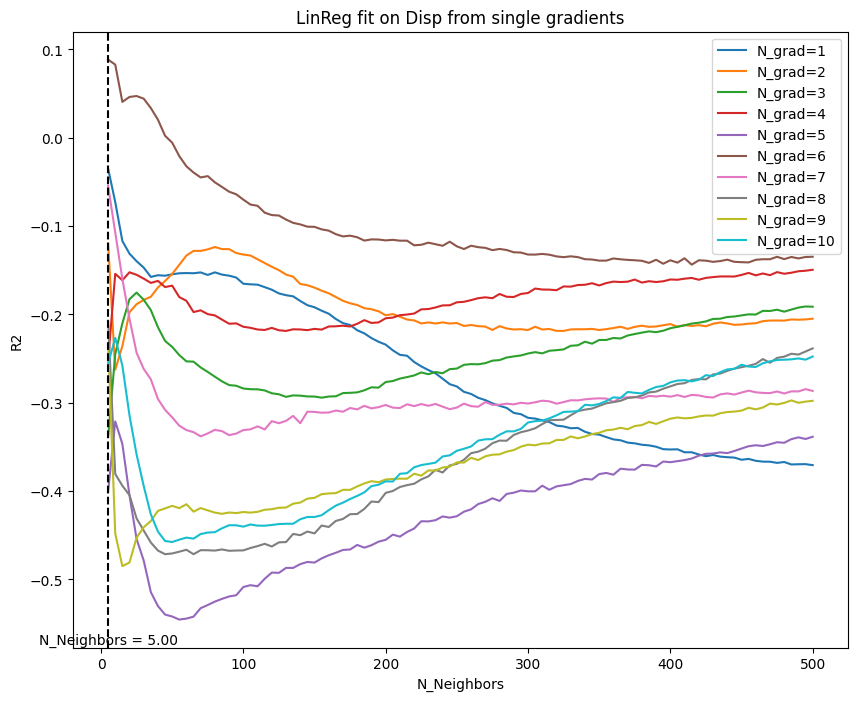

In [46]:
# Get the mean and SEM of Rel_Error for each combination of N_grads and N_Neighbors:
grouped = lingreg_loocv_disp_single_grads_panss_results.groupby(['N_grads', 'N_Neighbors'])['Rel_Error'].agg(['mean']).reset_index()
grouped_r2 = lingreg_loocv_disp_single_grads_panss_results.groupby(['N_grads', 'N_Neighbors'])['R2_Test'].agg(['mean']).reset_index()

min_mean_error = grouped['mean'].min()
r2_max = grouped_r2['mean'].max()

# Set up the plot:
fig, ax = plt.subplots(figsize=(10,8))

# Loop over each unique N_grads value:
for n_grads_val in grouped_r2['N_grads'].unique():
    # Filter the data to only include rows with this N_grads value:
    subset = grouped_r2[grouped_r2['N_grads'] == n_grads_val]
    
    # Plot a line for this N_grads value:
    ax.plot(subset['N_Neighbors'], subset['mean'], label=f'N_grad={n_grads_val}')

    
# Add labels and legend:
ax.set_xlabel('N_Neighbors')
ax.set_ylabel('R2')
ax.legend()

# Add title
ax.set_title('LinReg fit on Disp from single gradients')

#xticks = grouped['N_Neighbors'].unique()
#ax.set_xticks(xticks)

#xticklabels = [str(x) for x in xticks]
#ax.set_xticklabels(xticklabels)


# Add vertical line at the value of N_Neighbors corresponding to the minimum mean Rel_Error:
min_error_neighbors = grouped.loc[grouped['mean'] == min_mean_error, 'N_Neighbors'].iloc[0]
max_r2_neighbors = grouped_r2.loc[grouped_r2['mean'] == r2_max, 'N_Neighbors'].iloc[0]

#ax.text(min_error_neighbors, ax.get_ylim()[0], f'N_Neighbors = {min_error_neighbors:.2f}', ha='center', va='bottom')
#ax.axvline(min_error_neighbors, color='k', linestyle='--')
ax.axvline(max_r2_neighbors, color='k', linestyle='--')
ax.text(max_r2_neighbors, ax.get_ylim()[0], f'N_Neighbors = {max_r2_neighbors:.2f}', ha='center', va='bottom')

ax.legend(loc='upper right')
# Show the plot:
plt.show()

# save figure
fig.savefig('perf_linreg_single_grads.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'N_Neighbors')

Text(0, 0.5, 'R2')

Text(0.5, 1.0, 'LinReg fit on combinations of gradients')

Text(110, -0.39077696250235927, 'N_Neighbors = 110.00')

Text(0.05, 0.95, 'Max R2 = 0.030')

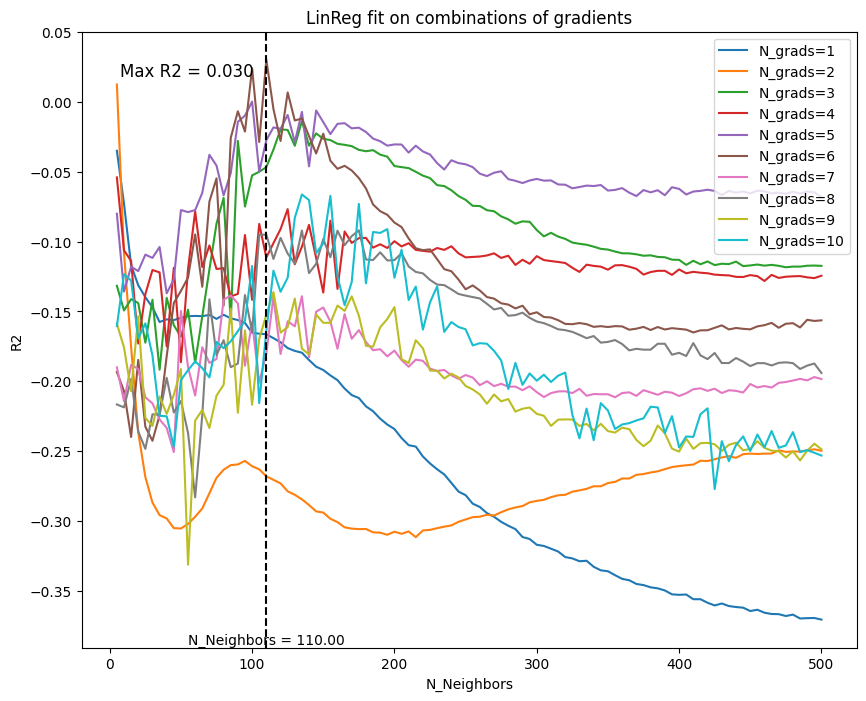

In [48]:
# Get the mean and SEM of Rel_Error for each combination of N_grads and N_Neighbors:
grouped = lingreg_loocv_disp_panss_results.groupby(['N_grads', 'N_Neighbors'])['Rel_Error'].agg(['mean']).reset_index()
grouped_r2 = lingreg_loocv_disp_panss_results.groupby(['N_grads', 'N_Neighbors'])['R2_Test'].agg(['mean']).reset_index()

min_mean_error = grouped['mean'].min()
r2_max = grouped_r2['mean'].max()

# Set up the plot:
fig, ax = plt.subplots(figsize=(10,8))

# Loop over each unique N_grads value:
for n_grads_val in grouped_r2['N_grads'].unique():
    # Filter the data to only include rows with this N_grads value:
    subset = grouped_r2[grouped_r2['N_grads'] == n_grads_val]
    
    # Plot a line for this N_grads value:
    ax.plot(subset['N_Neighbors'], subset['mean'], label=f'N_grads={n_grads_val}')

    
# Add labels and legend:
ax.set_xlabel('N_Neighbors')
ax.set_ylabel('R2')
ax.legend()

# Add title
ax.set_title('LinReg fit on combinations of gradients')

#xticks = grouped['N_Neighbors'].unique()
#ax.set_xticks(xticks)

#xticklabels = [str(x) for x in xticks]
#ax.set_xticklabels(xticklabels)

# Add vertical line at the value of N_Neighbors corresponding to the minimum mean Rel_Error:
min_error_neighbors = grouped.loc[grouped['mean'] == min_mean_error, 'N_Neighbors'].iloc[0]
max_r2_neighbors = grouped_r2.loc[grouped_r2['mean'] == r2_max, 'N_Neighbors'].iloc[0]
#ax.text(min_error_neighbors, ax.get_ylim()[0], f'N_Neighbors = {min_error_neighbors:.2f}', ha='center', va='bottom')
#ax.text(0.05, 0.95, f"Minimal Mean Rel_Error = {min_mean_error:.3f}", transform=ax.transAxes, fontsize=12, va='top')

ax.text(max_r2_neighbors, ax.get_ylim()[0], f'N_Neighbors = {max_r2_neighbors:.2f}', ha='center', va='bottom')
ax.text(0.05, 0.95, f"Max R2 = {r2_max:.3f}", transform=ax.transAxes, fontsize=12, va='top')


ax.axvline(max_r2_neighbors, color='k', linestyle='--')
ax.legend(loc='upper right')
# Show the plot:
plt.show()

# save figure
fig.savefig('perf_linreg_single_grads.png', dpi=300, bbox_inches='tight')

In [ ]:
subject = 'A00014804'
n_grads = 1
arr = np.expand_dims(np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, n_grads - 1], axis=1)
arr.shape

In [ ]:
arr

In [ ]:
n_neighbours_list = np.concatenate([np.arange(5, 505, 5)] * 10)
n_grads_list = np.concatenate([np.array([i] * 100) for i in np.arange(1, 11)])
args_list = np.stack([n_grads_list, n_neighbours_list]).T

np.savetxt('args_panss_linreg.txt', args_list, fmt='%d')


In [ ]:
scz_subjects